In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ghibtools as gh
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin
from compute_global_dataframes import resp_features_concat_job
from params import *
import physio
from configuration import base_folder, base_cmo
import os
from bibliotheque import df_baseline

In [3]:
resp = resp_features_concat_job.get(global_key).to_dataframe()

In [4]:
resp

,inspi_index,expi_index,next_inspi_index,inspi_time,expi_time,next_inspi_time,cycle_duration,inspi_duration,expi_duration,cycle_freq,...,total_volume,participant,session,artifact,stai_state,stai_trait,Gender,Maia_Mean,OAS,BMRQ
dim_0,,,,,,,,,,,,,,,,,,,,,
0,1768,2812,4587,1.768,2.812,4.587,2.819,1.044,1.775,0.354736,...,91.345496,P01,baseline,0,40,61,F,1.019643,2.666667,2.727273
1,4587,5604,7284,4.587,5.604,7.284,2.697,1.017,1.680,0.370782,...,98.100673,P01,baseline,0,40,61,F,1.019643,2.666667,2.727273
2,7284,8321,10035,7.284,8.321,10.035,2.751,1.037,1.714,0.363504,...,124.107899,P01,baseline,0,40,61,F,1.019643,2.666667,2.727273
3,10035,11010,12671,10.035,11.010,12.671,2.636,0.975,1.661,0.379363,...,128.582426,P01,baseline,0,40,61,F,1.019643,2.666667,2.727273
4,12671,13642,15473,12.671,13.642,15.473,2.802,0.971,1.831,0.356888,...,119.114652,P01,baseline,0,40,61,F,1.019643,2.666667,2.727273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11720,574160,576201,578363,574.160,576.201,578.363,4.203,2.041,2.162,0.237925,...,358.299577,P31,odor,0,29,40,M,2.790774,2.933333,2.681818
11721,578363,579716,583318,578.363,579.716,583.318,4.955,1.353,3.602,0.201816,...,222.081131,P31,odor,1,29,40,M,2.790774,2.933333,2.681818
11722,583318,586111,588773,583.318,586.111,588.773,5.455,2.793,2.662,0.183318,...,515.306571,P31,odor,1,29,40,M,2.790774,2.933333,2.681818


In [5]:
resp.columns

Index(['inspi_index', 'expi_index', 'next_inspi_index', 'inspi_time',
       'expi_time', 'next_inspi_time', 'cycle_duration', 'inspi_duration',
       'expi_duration', 'cycle_freq', 'cycle_ratio', 'inspi_volume',
       'expi_volume', 'total_amplitude', 'inspi_amplitude', 'expi_amplitude',
       'total_volume', 'participant', 'session', 'artifact', 'stai_state',
       'stai_trait', 'Gender', 'Maia_Mean', 'OAS', 'BMRQ'],
      dtype='object')

In [6]:
metrics = ['cycle_duration','inspi_duration','expi_duration','cycle_ratio','inspi_volume','expi_volume','total_volume', 'inspi_amplitude', 'expi_amplitude']
metrics_and_psycho = ['cycle_duration','inspi_duration','expi_duration','cycle_ratio','inspi_volume','expi_volume','total_volume', 'inspi_amplitude', 'expi_amplitude','stai_state','stai_trait', 'Maia_Mean','OAS','BMRQ']

In [7]:
clean_labels = {'cycle_duration':'Cycle Duration',
                'inspi_duration':'Inspiration Duration',
                'expi_duration':'Expiration Duration',
                'cycle_ratio':'Cycle Ratio',
                'inspi_volume':'Inspiration Volume',
                'expi_volume':'Expiration Volume',
                'total_volume':'Total Cycle Volume', 
                'inspi_amplitude':'Inspiration Amplitude', 
                'expi_amplitude':'Expiration Amplitude'
               }

units = {'cycle_duration':'sec',
                'inspi_duration':'sec',
                'expi_duration':'sec',
                'cycle_ratio':None,
                'inspi_volume':'AU',
                'expi_volume':'AU',
                'total_volume':'AU', 
                'inspi_amplitude':'AU', 
                'expi_amplitude':'AU'
               }

In [8]:
indexes = ['participant','session']

In [9]:
resp = resp.groupby(indexes).median(True).reset_index()

In [10]:
all_cols = indexes + metrics_and_psycho

In [11]:
resp_baselined = df_baseline(resp[all_cols], indexes, metrics)

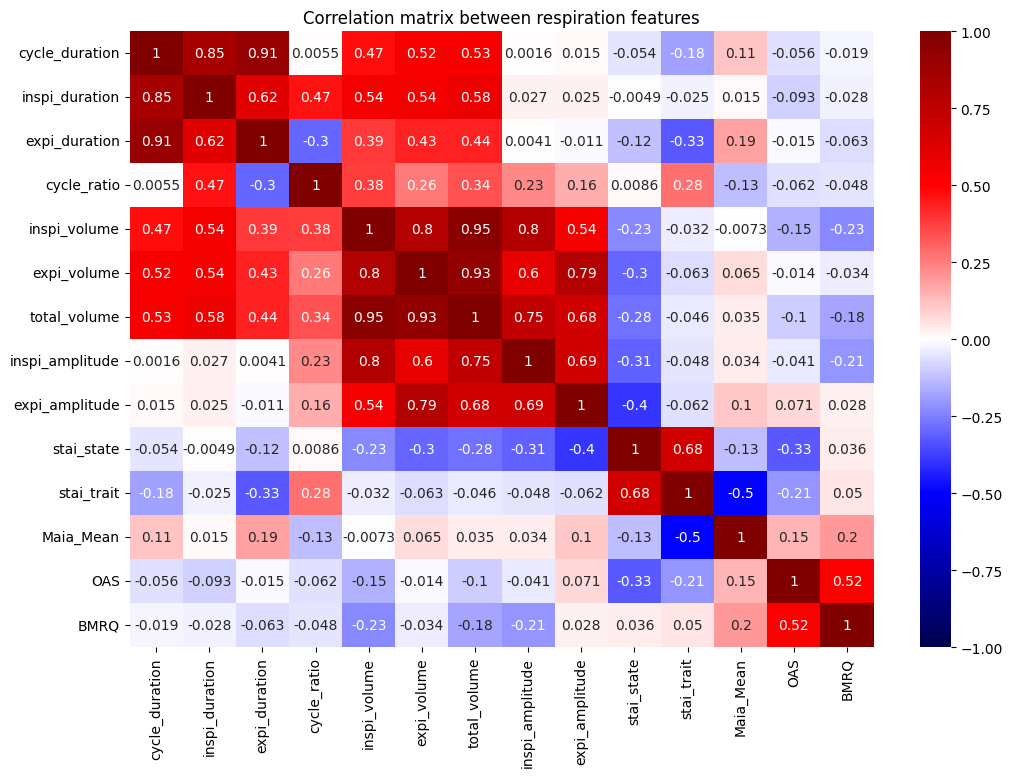

In [12]:
fig, ax = plt.subplots(figsize = (12,8))
sns.heatmap(resp[metrics_and_psycho].corr('spearman',numeric_only = True), annot = True, vmin=-1, vmax= 1 , cmap = 'seismic', ax=ax)
ax.set_title('Correlation matrix between respiration features')
file = base_folder / 'Figures' / 'resp_features' / 'corr_matrix_resp_features.png'
fig.savefig(file, bbox_inches = 'tight')
plt.show()

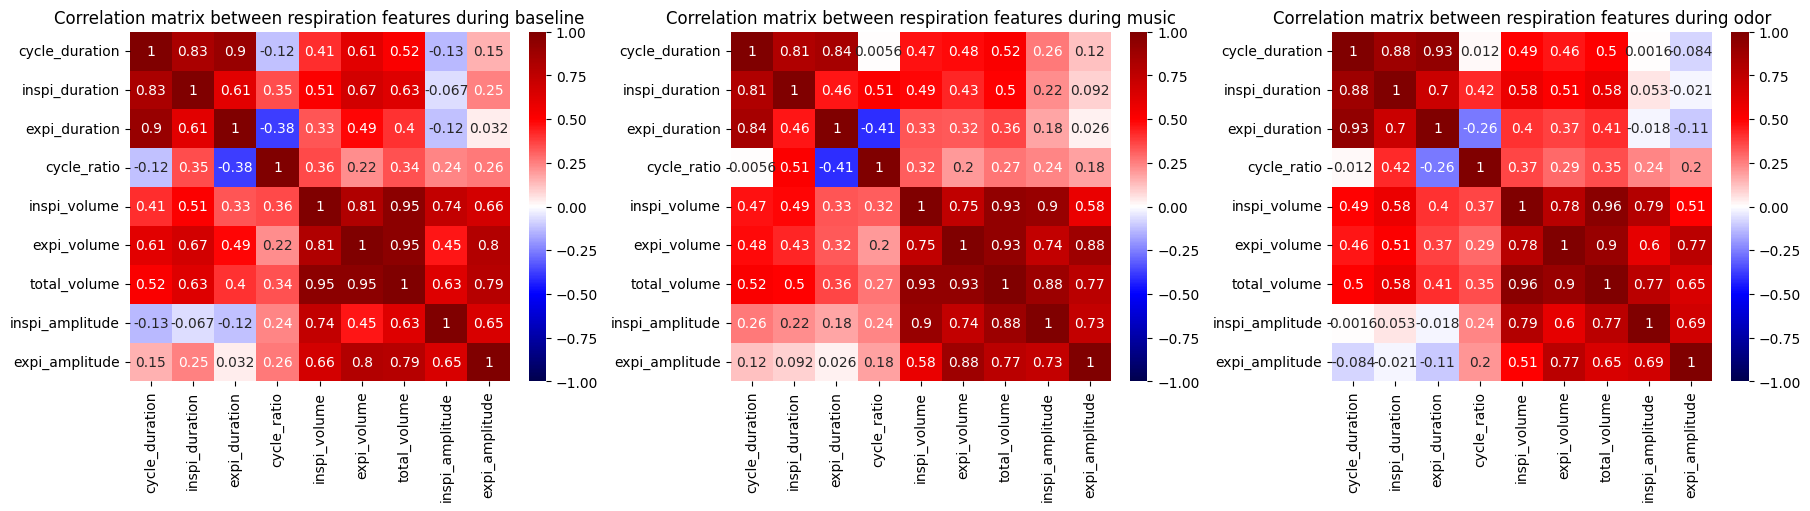

In [13]:
fig, axs = plt.subplots(ncols = 3, figsize = (18,5), constrained_layout = True)

for c, ses in enumerate(session_keys):
    ax = axs[c]
    resp_ses = resp[resp['session'] == ses]
    sns.heatmap(resp_ses[metrics].corr('spearman',numeric_only = True), annot = True, vmin=-1, vmax= 1 , cmap = 'seismic', ax=ax)
    ax.set_title(f'Correlation matrix between respiration features during {ses}')
    
file = base_folder / 'Figures' / 'resp_features' / 'corr_matrix_resp_features_by_session.png'
fig.savefig(file, bbox_inches = 'tight')
plt.show()

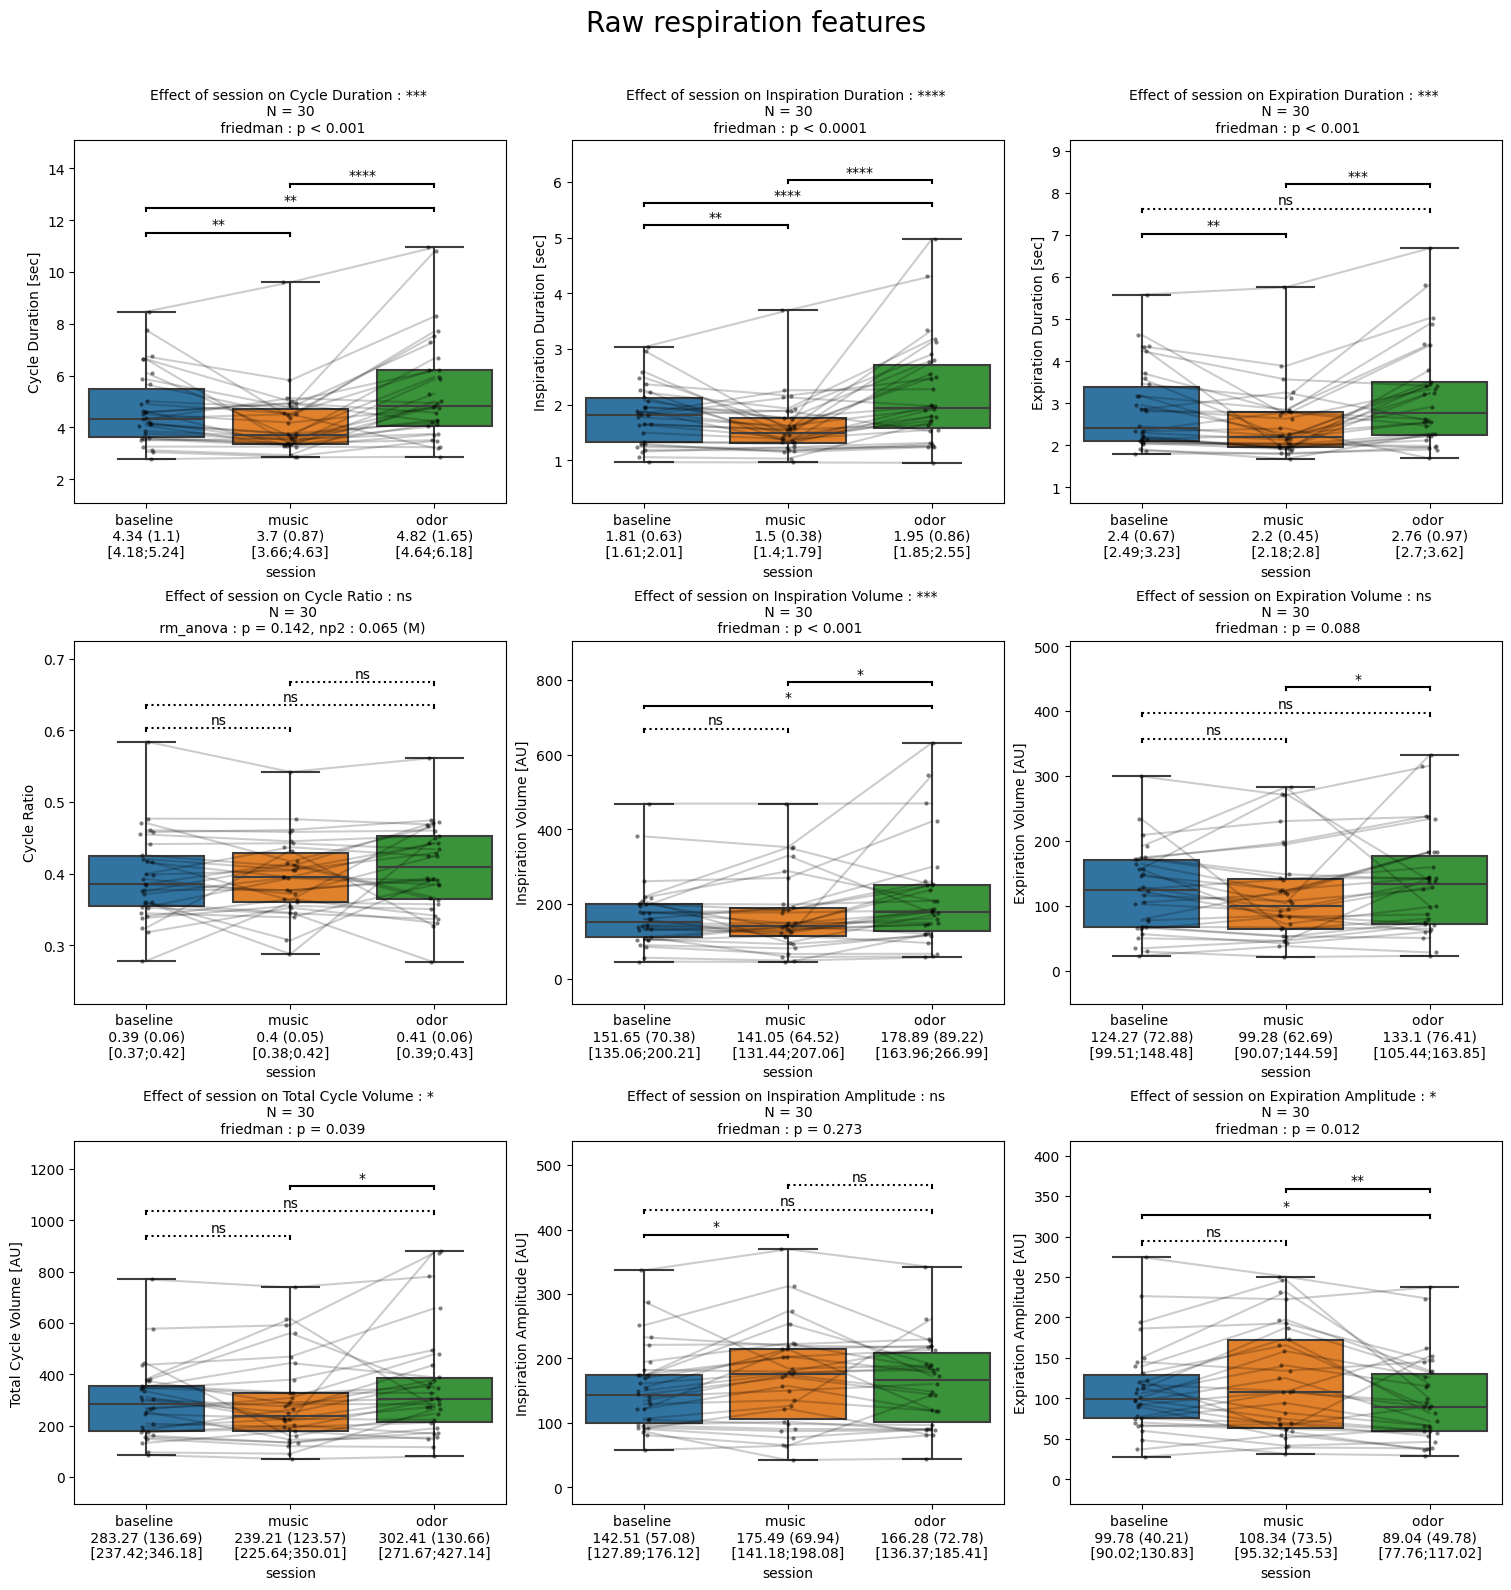

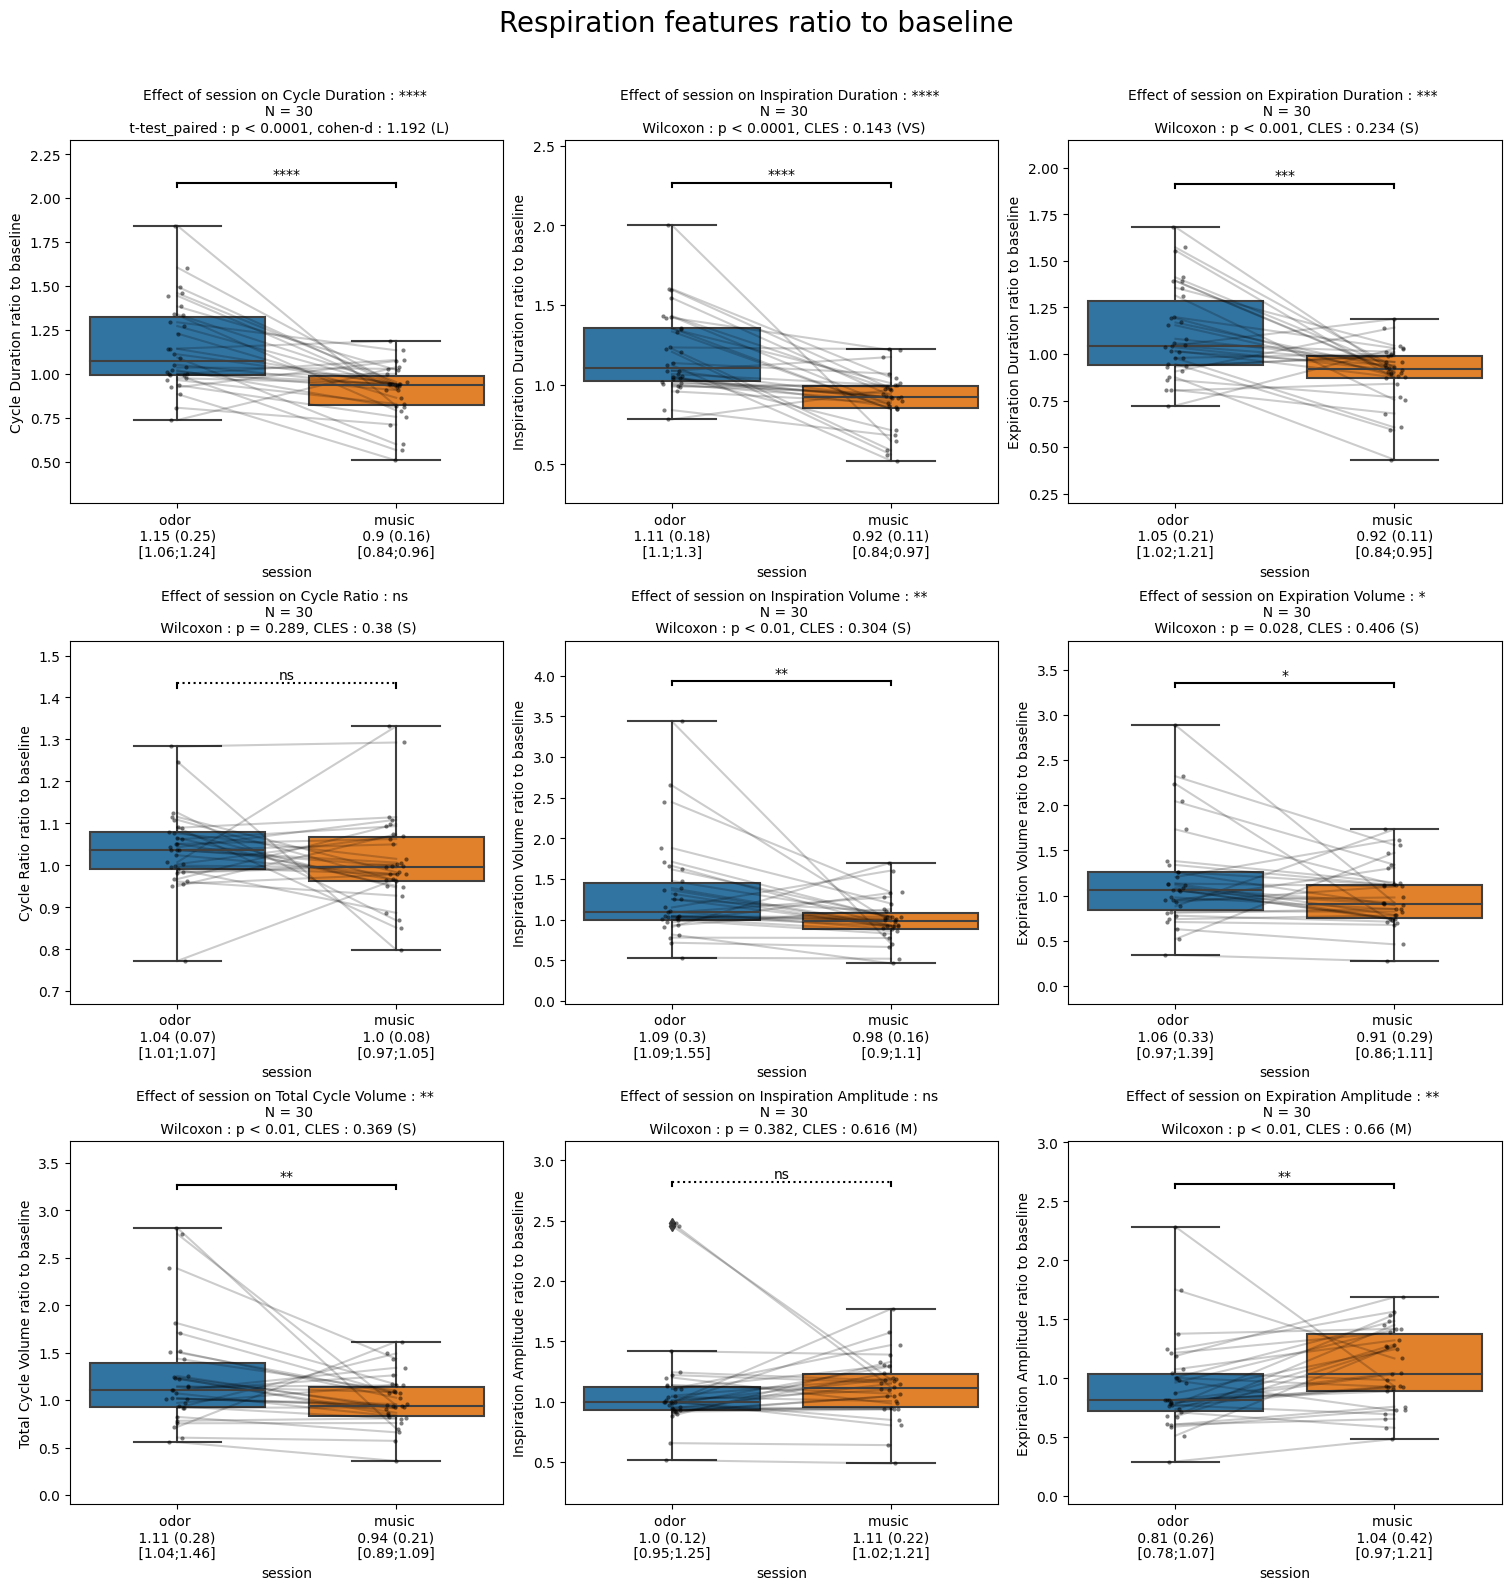

In [14]:
nrows = 3
ncols = 3
plot_metrics = np.array(metrics).reshape(nrows, ncols)

for suptitle, df in zip(['Raw respiration features','Respiration features ratio to baseline'],[resp, resp_baselined]):

    fig, axs = plt.subplots(nrows, ncols, figsize = (15,15), constrained_layout = True)
    fig.suptitle(suptitle, fontsize = 20, y = 1.05)

    for r in range(nrows):
        for c in range(ncols):
            ax = axs[r,c]
            
            metric = plot_metrics[r,c]
            
            if suptitle == 'Respiration features ratio to baseline':
                outcome_unit = None
            else:
                outcome_unit = units[metric]
            
            gh.auto_stats(df = df, 
                          predictor = 'session', 
                          outcome = metric, 
                          design = 'within',
                          subject = 'participant', 
                          ax=ax,
                         outcome_clean_label = clean_labels[metric],
                         outcome_unit = units[metric],
                         strip = True,
                         lines = True,
                         xtick_info = True)
            
            if suptitle == 'Respiration features ratio to baseline':
                ax.set_ylabel(f'{clean_labels[metric]} ratio to baseline')
                
    file = base_folder / 'Figures' / 'resp_features' / f'{suptitle}.png'
    fig.savefig(file, bbox_inches = 'tight')
    plt.show()

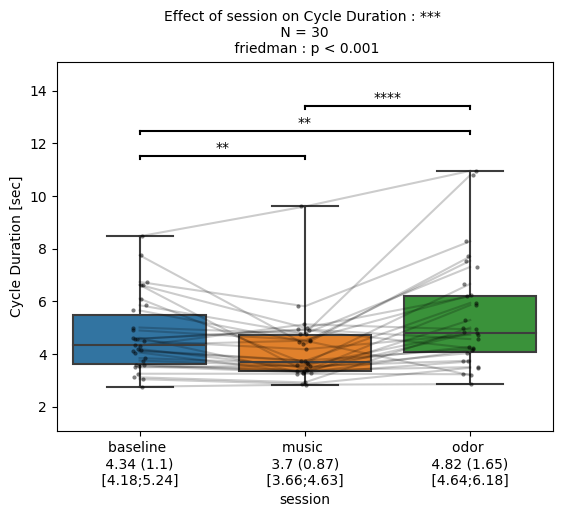

In [15]:

fig, ax = plt.subplots()
        
gh.auto_stats(df = resp, 
              predictor = 'session', 
              outcome = 'cycle_duration', 
              design = 'within',
              subject = 'participant', 
              ax=ax,
             outcome_clean_label = 'Cycle Duration',
             outcome_unit = 'sec',
             strip = True,
             lines = True,
             xtick_info = True)

                
file = base_folder / 'Figures' / 'resp_features' / f'cycle_duration_clean.png'
fig.savefig(file, bbox_inches = 'tight', dpi = 300)
plt.show()

## FIG SOUTENANCE

/tmp/ipykernel_30232/3670024742.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize = fontsize)


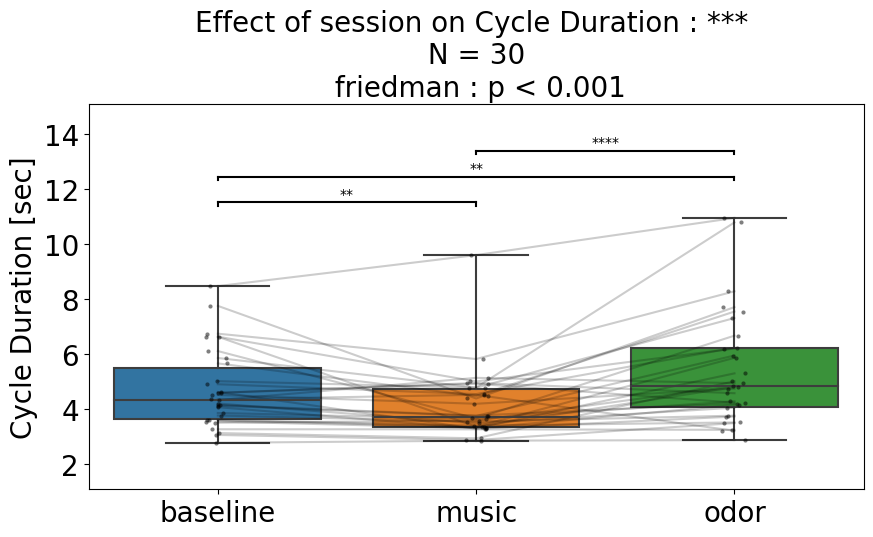

In [16]:
fig , ax = plt.subplots(figsize = (10,5))

fontsize = 20

gh.auto_stats(df = resp, 
              predictor = 'session', 
              outcome = 'cycle_duration', 
              design = 'within', 
              subject = 'participant', 
              ax=ax, 
              outcome_clean_label = 'Cycle Duration', 
              outcome_unit = 'sec',
             strip = True,
             lines = True,
             xtick_info = False,
             fontsize = fontsize)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = fontsize)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = fontsize)
ax.set_xlabel(None)
ax.set_ylabel(ax.get_ylabel(), fontsize=fontsize)

file =  base_cmo / 'users' / 'ValentinGhibaudo' / 'Rédaction_Thèse' / 'Soutenance_Thèse' / 'figures' / 'emosens3_resp.png'
fig.savefig(file, bbox_inches = 'tight', dpi = 500)

# SAVE STATS

In [17]:
stats = gh.auto_stats_summary(df = resp, predictor = 'session', outcome = 'cycle_duration', design = 'within', subject = 'participant')
file = base_folder / 'Tables' / 'stats_respi.xlsx'
gh.save_auto_stats_summary(stats, file)

# DURATION, AMPLITUDE, VOLUME

In [18]:
resp_bis = resp.copy()
resp_bis['total_duration_to_amplitude'] = resp_bis['cycle_duration'] * resp_bis['total_amplitude']
resp_bis['inspi_duration_to_amplitude'] = resp_bis['inspi_duration'] * resp_bis['inspi_amplitude']
resp_bis['expi_duration_to_amplitude'] = resp_bis['expi_duration'] * resp_bis['expi_amplitude']

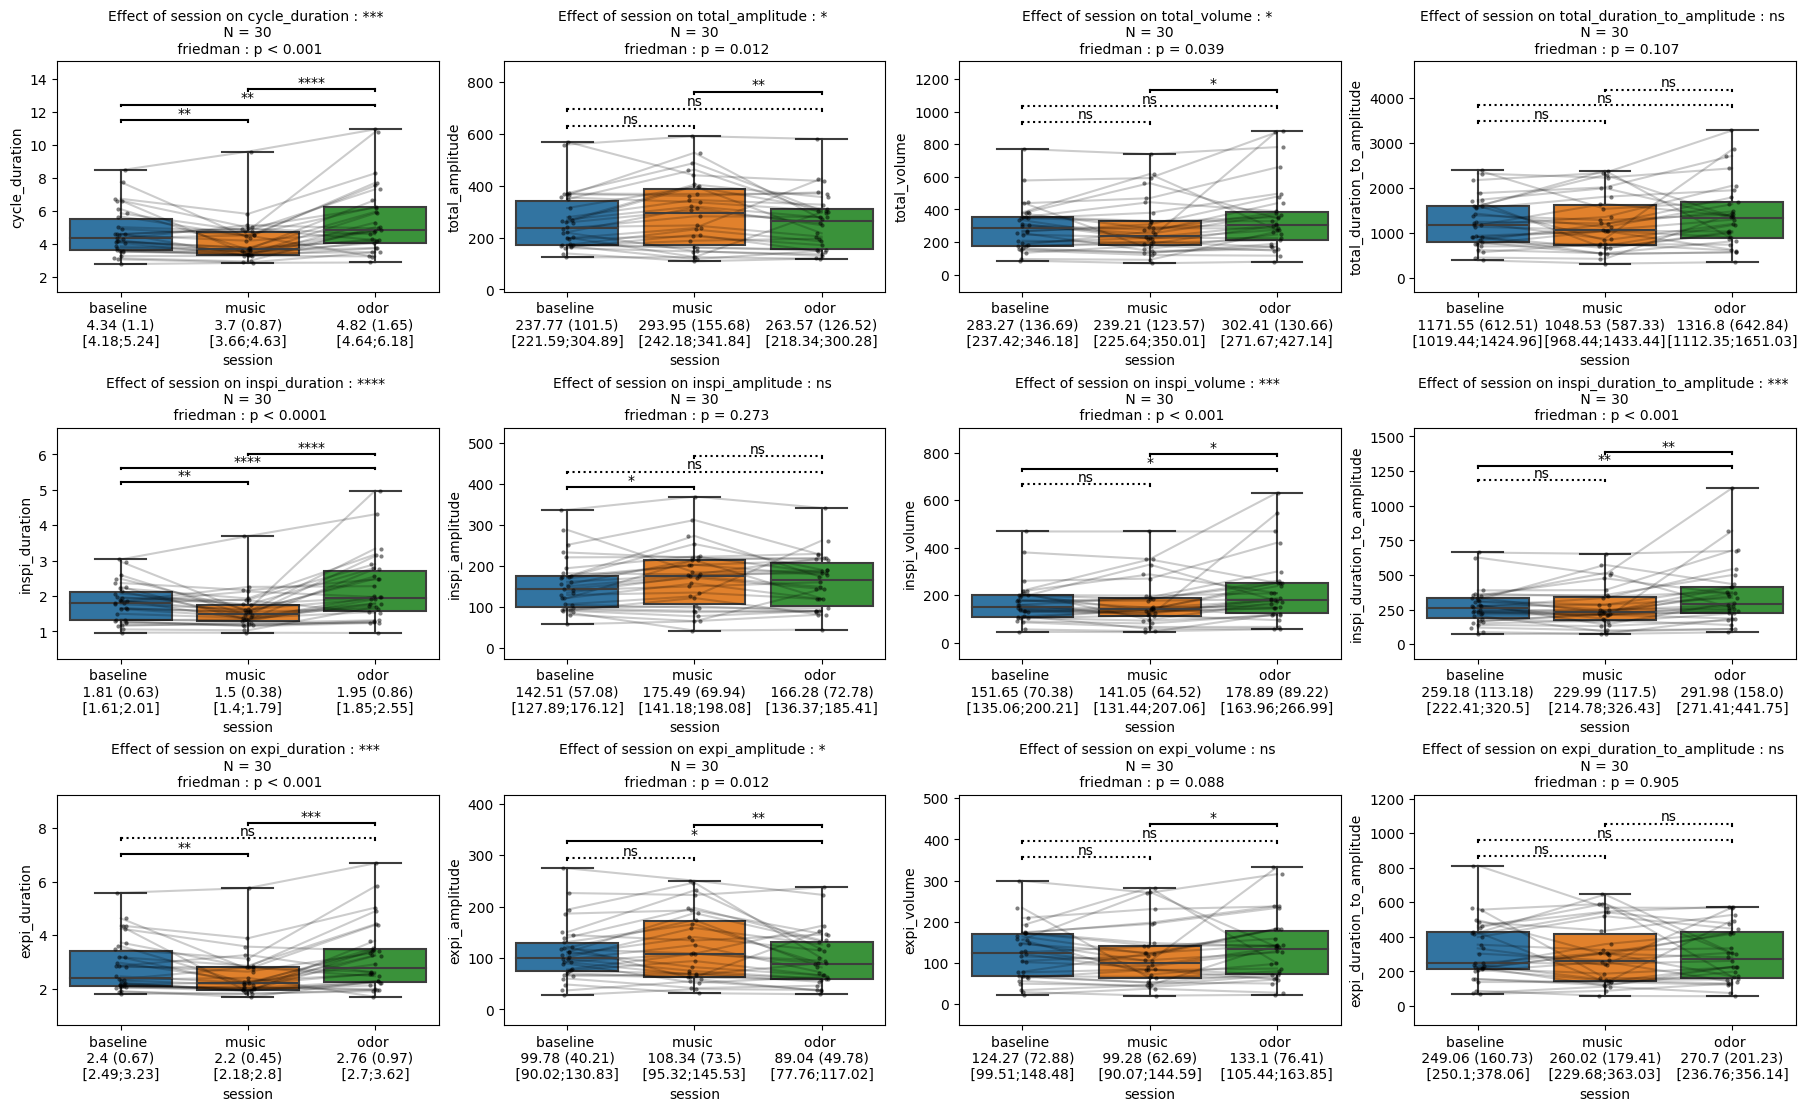

In [19]:
cols = ['cycle_duration','total_amplitude','total_volume','total_duration_to_amplitude',
       'inspi_duration','inspi_amplitude','inspi_volume','inspi_duration_to_amplitude',
        'expi_duration','expi_amplitude','expi_volume','expi_duration_to_amplitude',
       ]

nrows = 3
ncols = 4

cols_array = np.array(cols).reshape(nrows,ncols)

fig, axs = plt.subplots(nrows, ncols, figsize = (18,11), constrained_layout = True)

for r in range(nrows):
    for c in range(ncols):
        ax = axs[r,c]
        col = cols_array[r,c]
        gh.auto_stats(df = resp_bis,
                      predictor = 'session',
                      outcome = col,
                      subject = 'participant',
                      ax=ax,
                      xtick_info = True,
                      force_post_hoc=True,
                      transform = False
                     )
savefile = base_folder / 'Figures' / 'resp_features' / 'duration_amplitude_volume_test.png'
fig.savefig(savefile, dpi = 500, bbox_inches = 'tight')
plt.show()


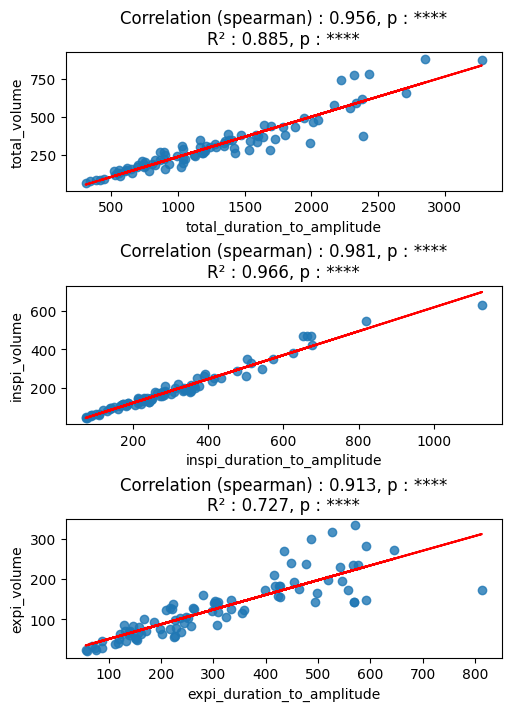

In [20]:
fig, axs = plt.subplots(nrows = 3, figsize = (5,7), constrained_layout = True)

for r, feature in enumerate(['total','inspi','expi']):
    ax = axs[r]
    gh.stats_quantitative(df = resp_bis, xlabel = f'{feature}_duration_to_amplitude', ylabel = f'{feature}_volume', ax=ax, corr_method = 'spearman')
savefile = base_folder / 'Figures' / 'resp_features' / 'duration_amplitude_volume_test_corrs.png'
fig.savefig(savefile, dpi = 500, bbox_inches = 'tight')
plt.show()

# RESP VARIABILITY

In [27]:
resp_variability = resp_features_concat_job.get(global_key).to_dataframe()

In [28]:
metric = 'cycle_duration'
rows = []
resp_variability = resp_variability.set_index(['participant','session'])
for participant in resp['participant'].unique():
    for session in resp['session'].unique():
        data = resp_variability.loc[(participant,session),metric]
        med, mad = physio.compute_median_mad(data)
        mean, std = np.mean(data), np.std(data)
        cv = std / mean
        rcv = mad / med
        rows.append([participant,session, med, mad, rcv, mean, std, cv])
res = pd.DataFrame(rows, columns = ['participant','session','med','mad','rcv','mean','std','cv'])

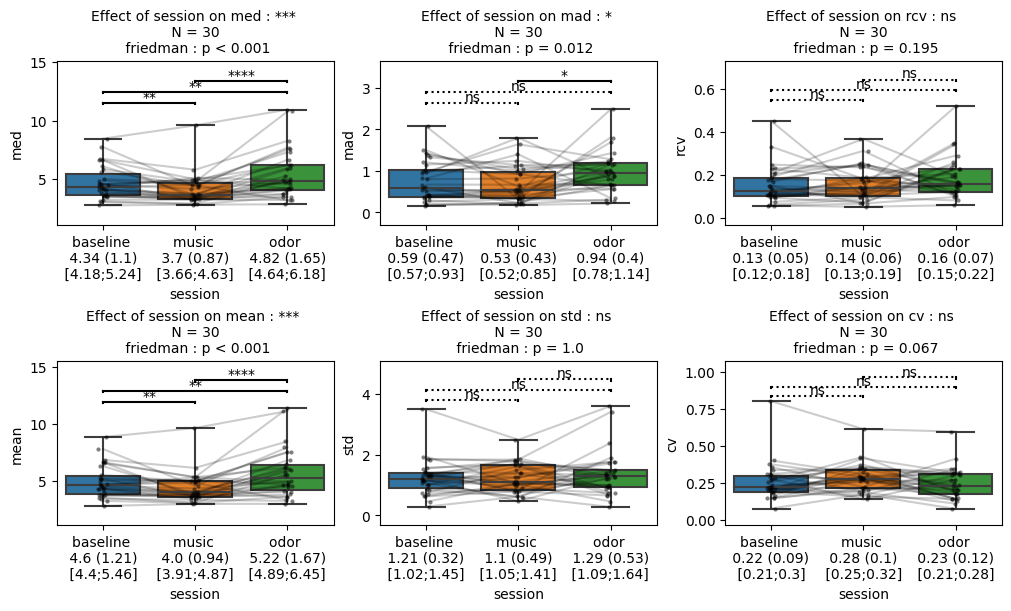

In [34]:
metrics = ['med','mad','rcv','mean','std','cv']
nrows = 2
ncols = 3
subplots = gh.attribute_subplots(metrics, nrows, ncols)
fig, axs = plt.subplots(nrows=nrows, ncols = ncols, figsize = (10, 6), constrained_layout = True)
for metric, subplot in subplots.items():
    ax = axs[subplot[0], subplot[1]] 
    gh.auto_stats(df = res, predictor = 'session', outcome = metric, subject = 'participant', ax=ax, transform = False)
# fig.savefig(base_folder / 'Figures' / 'resp_features' / 'resp_variability.png', dpi = 500, bbox_inches = 'tight')
plt.show()